# 8. 컴퓨터 비전을 위한 딥러닝
## 8.1 합성곱 신경망 소개

In [1]:
# 8-1 간단한 컨브넷 만들기

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

C:\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 8-2 모델의 summary() 메서드 출력

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          9248  

In [3]:
# 8-3 MNIST 이미지에서 컨브넷 훈련하기

from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
938/938 [==============================] - 27s 28ms/step - loss: 0.2278 - accuracy: 0.9297
Epoch 2/5
938/938 [==============================] - 50s 53ms/step - loss: 0.0690 - accuracy: 0.9792
Epoch 3/5
938/938 [==============================] - 56s 59ms/step - loss: 0.0488 - accuracy: 0.9843
Epoch 4/5
938/938 [==============================] - 27s 29ms/step - loss: 0.0396 - accuracy: 0.9879
Epoch 5/5
938/938 [==============================] - 29s 31ms/step - loss: 0.0322 - accuracy: 0.9902


In [4]:
# 8-4 컨브넷 평가하기

test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"테스트 정확도: {test_acc:.3f}")

313/313 [==============================] - 3s 8ms/step - loss: 0.0330 - accuracy: 0.9892
테스트 정확도: 0.989


# 8.1.2 최대 풀링 연산

In [5]:
# 8-5 최대 풀링 층이 빠진 잘못된 구조의 컨브넷

inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

# 8.2 소규모 데이터셋에서 밑바닥부터 컨브넷 훈련하기
## 8.2.2 데이터 내려받기

In [15]:
import zipfile
import pathlib

# Assuming the 'dogs-vs-cats.zip' file is in the /content directory
zip_path = pathlib.Path("/dogs-vs-cats.zip")
extract_dir = pathlib.Path("/dogs-vs-cats")

if zip_path.exists():
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# After extraction, verify the 'train' directory is inside
for dirpath, dirnames, filenames in os.walk(extract_dir):
    if 'train' in dirnames:
        print(f"Found 'train' directory at: {dirpath}")

In [41]:
import zipfile
import pathlib

# Paths to the zip files
train_zip_path = pathlib.Path("C:/dogs-vs-cats/train")
test_zip_path = pathlib.Path("C:/dogs-vs-cats/test1.zip")
extract_dir = pathlib.Path("/dogs-vs-cats")


# Verify the contents of the train and test folders
for dirpath, dirnames, filenames in os.walk(extract_dir / "train"):
    print(f"Directory: {dirpath}")
    print(f"Files: {filenames[:10]}")  # Show the first 10 files

Directory: \dogs-vs-cats\train
Files: []
Directory: \dogs-vs-cats\train\train
Files: ['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg']


In [42]:
import os
import shutil
import pathlib

# 원본 파일 경로 설정
original_dir = pathlib.Path("C:/dogs-vs-cats/train/train")

# 새로운 데이터셋을 저장할 경로 설정 (로컬 경로)
new_base_dir = pathlib.Path("C:/cats_vs_dogs_small_subset")

# 서브셋 생성 함수
def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        # 카테고리별 디렉토리 생성
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        
        # 파일 이름 리스트 생성
        fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
        
        # 파일 복사
        for fname in fnames:
            src_path = original_dir / fname
            if src_path.exists():
                shutil.copyfile(src=src_path, dst=dir / fname)
            else:
                print(f"File not found: {src_path}")

# 서브셋 만들기
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


# 8.2.3 모델 만들기

In [43]:
# 8-7 강아지 vs 고양이 분류를 위한 소규모 컨브넷 만들기

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                     

In [44]:
# 8-8 모델 훈련 설정하기

model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

# 8.2.4 데이터 전처리

In [45]:
# 8-9 image_dataset_from_directory를 사용하여 이미지 읽기

from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)

validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)

test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [46]:
# 8-10 Dataset이 반환하는 데이터와 레이블 크기 확인하기

for data_batch, labels_batch in train_dataset:
  print("데이터 배치 크기: ", data_batch.shape)
  print("레이블 배치 크기: ", labels_batch.shape)
  break

데이터 배치 크기:  (32, 180, 180, 3)
레이블 배치 크기:  (32,)


In [54]:
# 8-11 Dataset을 사용하여 모델 훈련하기

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.h5",
        save_best_only=True,
        monitor='val_loss')
]

history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
63/63 [==============================] - 67s 1s/step - loss: 0.2241 - accuracy: 0.9065 - val_loss: 0.7604 - val_accuracy: 0.7150
Epoch 2/10
63/63 [==============================] - 69s 1s/step - loss: 0.1873 - accuracy: 0.9285 - val_loss: 0.8752 - val_accuracy: 0.7160
Epoch 3/10
63/63 [==============================] - 68s 1s/step - loss: 0.1427 - accuracy: 0.9490 - val_loss: 0.8427 - val_accuracy: 0.7310
Epoch 4/10
63/63 [==============================] - 70s 1s/step - loss: 0.1210 - accuracy: 0.9620 - val_loss: 0.9615 - val_accuracy: 0.7370
Epoch 5/10
63/63 [==============================] - 76s 1s/step - loss: 0.0868 - accuracy: 0.9705 - val_loss: 1.3184 - val_accuracy: 0.7210
Epoch 6/10
63/63 [==============================] - 67s 1s/step - loss: 0.0801 - accuracy: 0.9735 - val_loss: 1.1096 - val_accuracy: 0.7380
Epoch 7/10
63/63 [==============================] - 83s 1s/step - loss: 0.0618 - accuracy: 0.9790 - val_loss: 1.5533 - val_accuracy: 0.7180
Epoch 8/10
63/63 [==

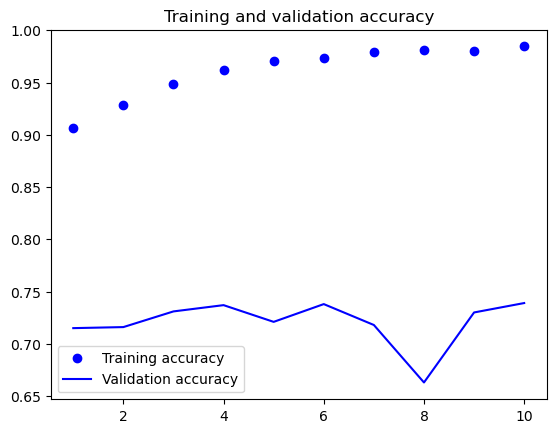

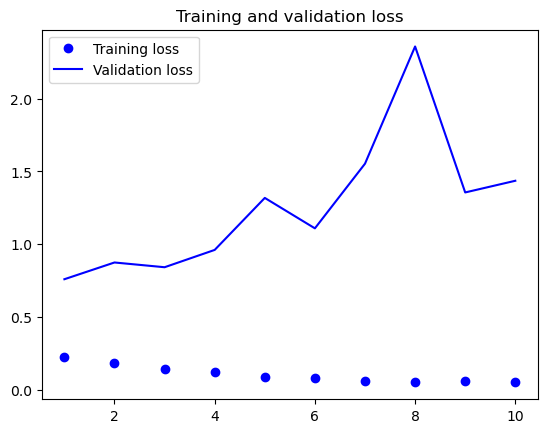

In [55]:
# 8-12 훈련 과정의 정확도와 손실 그래프 그리기

import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label='Training loss')
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [56]:
# 8-13 테스트 세트에서 모델 평가하기

import os

file_path = "convnet_from_scratch.h5"
if os.path.exists(file_path):
    print("파일이 존재합니다.")
else:
    print("파일을 찾을 수 없습니다.")

파일이 존재합니다.


# 8.2.5 데이터 증식 사용하기

In [57]:
# 8-14 컨브넷에 추가할 데이터 증식 단계 정의하기

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

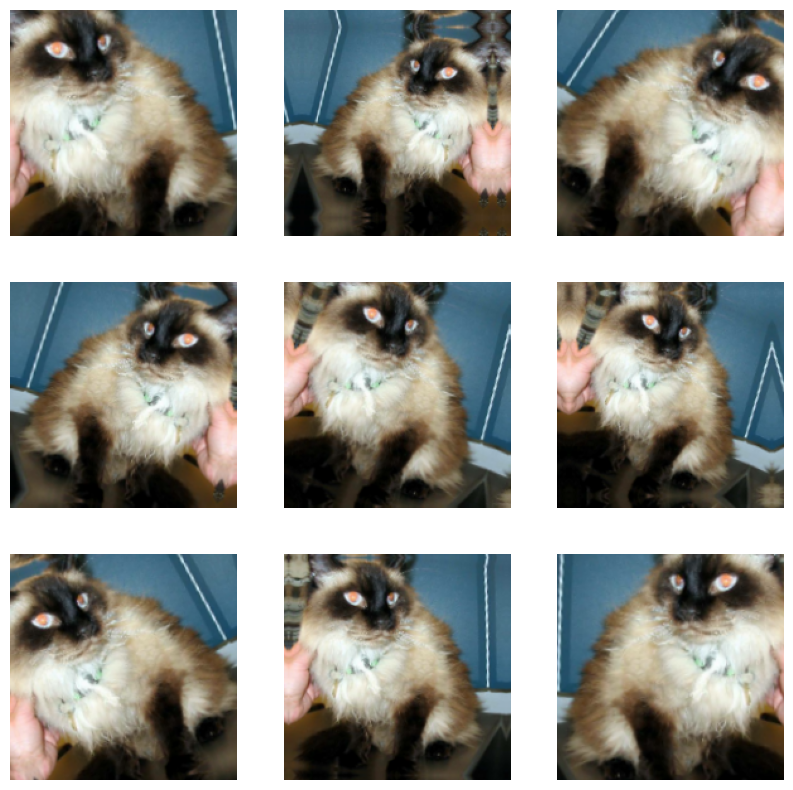

In [58]:
# 8-15 랜덤하게 증식된 훈련 이미지 출력하기

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.axis("off")

In [59]:
# 8-16 이미지 증식과 드롭아웃을 포함한 컨브넷 만들기

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer='rmsprop',
              metrics=['accuracy'])

In [62]:
# 8-17 규제를 추가한 컨브넷 훈련하기

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'convnet_from_scratch_with_augmentation.h5',
        save_best_only=True,
        monitor='val_loss')
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks
)

Epoch 1/10
63/63 [==============================] - 228s 4s/step - loss: 0.5621 - accuracy: 0.7185 - val_loss: 0.5970 - val_accuracy: 0.6760
Epoch 2/10
63/63 [==============================] - 347s 6s/step - loss: 0.5526 - accuracy: 0.7170 - val_loss: 0.5752 - val_accuracy: 0.6920
Epoch 3/10
63/63 [==============================] - 271s 4s/step - loss: 0.5407 - accuracy: 0.7190 - val_loss: 0.7864 - val_accuracy: 0.6560
Epoch 4/10
63/63 [==============================] - 255s 4s/step - loss: 0.5366 - accuracy: 0.7260 - val_loss: 0.5208 - val_accuracy: 0.7450
Epoch 5/10
63/63 [==============================] - 229s 4s/step - loss: 0.5308 - accuracy: 0.7420 - val_loss: 0.5569 - val_accuracy: 0.7160
Epoch 6/10
63/63 [==============================] - 224s 4s/step - loss: 0.5105 - accuracy: 0.7420 - val_loss: 0.5449 - val_accuracy: 0.7320
Epoch 7/10
63/63 [==============================] - 240s 4s/step - loss: 0.4981 - accuracy: 0.7540 - val_loss: 0.5614 - val_accuracy: 0.7480
Epoch 8/10
63

In [63]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 14: invalid start byte

# 8.3 사전 훈련된 모델 활용하기
## 8.3.1 사전 훈련된 모델을 사용한 특성 추출

In [64]:
# 8-19 VGG16 합성곱 기반 층 만들기

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [65]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [66]:
# 8-20 VGG16 특성과 해당 레이블 추출하기

import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 4s 4s/step


In [67]:
# 8-21 밀집 연결 분류기 정의하고 훈련하기

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.h5",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=10,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 9s 103ms/step - loss: 18.4438 - accuracy: 0.9245 - val_loss: 12.3609 - val_accuracy: 0.9280
Epoch 2/10
63/63 [==============================] - 7s 104ms/step - loss: 2.9512 - accuracy: 0.9755 - val_loss: 6.5048 - val_accuracy: 0.9650
Epoch 3/10
63/63 [==============================] - 7s 114ms/step - loss: 1.8126 - accuracy: 0.9855 - val_loss: 3.6150 - val_accuracy: 0.9760
Epoch 4/10
63/63 [==============================] - 6s 101ms/step - loss: 0.7281 - accuracy: 0.9910 - val_loss: 4.6805 - val_accuracy: 0.9730
Epoch 5/10
63/63 [==============================] - 5s 85ms/step - loss: 1.1805 - accuracy: 0.9900 - val_loss: 9.0713 - val_accuracy: 0.9560
Epoch 6/10
63/63 [==============================] - 6s 98ms/step - loss: 0.9551 - accuracy: 0.9930 - val_loss: 4.5150 - val_accuracy: 0.9680
Epoch 7/10
63/63 [==============================] - 9s 142ms/step - loss: 0.4170 - accuracy: 0.9945 - val_loss: 3.8605 - val_accuracy: 0.9780
Epoch 

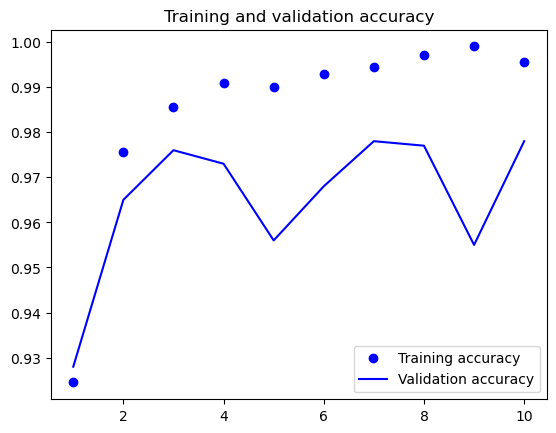

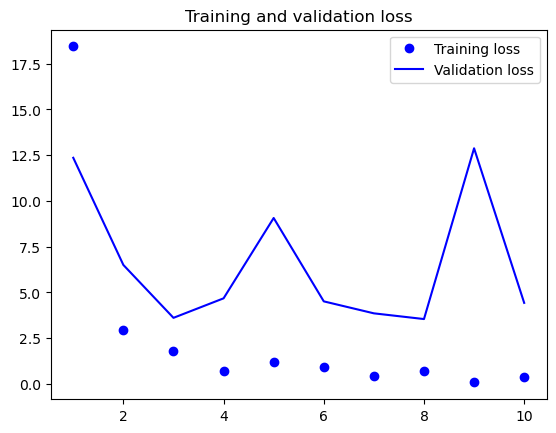

In [68]:
# 8-22 결과를 그래프로 나타내기

import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [70]:
# 8-23 VGG16 합성곱 기반 층을 만들고 동결하기

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [71]:
# 8-24 동결하기 전과 후에 훈련 가능한 가중치 리스트 출력하기

conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 26
합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


In [72]:
# 8-25 데이터 증식 단계와 밀집 분류기를 합성곱 기반 층에 추가하기

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [73]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - 857s 14s/step - loss: 22.9592 - accuracy: 0.8895 - val_loss: 16.1922 - val_accuracy: 0.9240
Epoch 2/10
63/63 [==============================] - 906s 14s/step - loss: 9.6836 - accuracy: 0.9340 - val_loss: 12.7563 - val_accuracy: 0.9390
Epoch 3/10
63/63 [==============================] - 672s 11s/step - loss: 7.4506 - accuracy: 0.9425 - val_loss: 3.2128 - val_accuracy: 0.9780
Epoch 4/10
63/63 [==============================] - 908s 15s/step - loss: 4.8473 - accuracy: 0.9560 - val_loss: 3.9574 - val_accuracy: 0.9710
Epoch 5/10
63/63 [==============================] - 908s 14s/step - loss: 4.7435 - accuracy: 0.9600 - val_loss: 3.2576 - val_accuracy: 0.9800
Epoch 6/10
63/63 [==============================] - 1137s 18s/step - loss: 4.7301 - accuracy: 0.9605 - val_loss: 3.4609 - val_accuracy: 0.9760
Epoch 7/10
63/63 [==============================] - 857s 14s/step - loss: 1.5090 - accuracy: 0.9840 - val_loss: 3.2940 - val_accuracy: 0.9770
Ep

In [75]:
# 8-26 테스트 세트에서 모델 평가하기

test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xac in position 14: invalid start byte

# 8.3.2 사전 훈련된 모델 미세 조정하기

In [76]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [77]:
# 8-27 마지막에서 네 번째 층까지 모든 층 동결하기

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
# 8-28 모델 미세 조정하기

model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.h5",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 1.6207 - accuracy: 0.9785